```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. https://shap.readthedocs.io/en/latest/
2. https://github.com/slundberg/shap

```

# Explaining Regression Models
Most of the techniques used to explain classification models apply to regression models. Here we will show how to use the `SHAP` library to interpret regression models.

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# To eliminate Yellowbrick warming: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
import matplotlib.font_manager

import seaborn as sns

In [4]:
df = get_dataset('boston_housing')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
# Missing values?
df.isnull().mean().value_counts()

0.0    14
dtype: int64

In [6]:
y = df[['medv']]
X = df.drop(columns=['medv'])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
import xgboost as xgb

#xgr = xgb.XGBRegressor(random_state=42, booster = 'gblinear', n_jobs=-1)
xgr = xgb.XGBRegressor(random_state=42, booster = 'gbtree', n_jobs=-1)
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## SHAP (SHapley Additive exPlanations)
[SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/) is model agnostic. This library also gives us global insight into our model and helps explain individual predictions. If you have a black-box model, you will find it very useful. It helps understand the global impact of features and also helps explain individual predictions.

We will first look at the prediction for index 5. Our model predicts the value to be 24.99.

In [9]:
sample_idx = 5
xgr.predict(X_train.iloc[[sample_idx]])

array([24.99756], dtype=float32)

To use the model, we have to create a `TreeExplaine`r from our model and estimate the `SHAP values` for our samples. If we want to use Jupyter and have an interactive interface, we also need to call the `initjs` function.

In [10]:
import shap
shap.initjs()

exp = shap.TreeExplainer(xgr)
vals = exp.shap_values(X_train)

### Force Plot
With the explainer and the SHAP values, we can create a `force plot` to explain the prediction. This informs us that the base prediction is 23, and that the population status (lstat) and black ratio (b) push the price up, while the number of rooms (RM) pushes the price down. The expected value is pushed up from 23 to 25 due to the population status and black rate. **This is different per sample (sample_idx)!**

In [14]:
shap.force_plot(exp.expected_value, 
                vals[sample_idx], 
                X_train.iloc[sample_idx],
               )

We can view the `force plot` for all of the samples as well to get an overall feel of the behavior. If we are using the interactive JavaScript mode on Jupyter, we can mouse over the samples and see what features are impacting the result.

In [15]:
shap.force_plot(
    exp.expected_value, vals, X_train
)

### Dependence Plot
From the `force plot` of the sample, we saw that the `lstat` feature had a big impact. To visualize how LSTAT affects the result, we can create a `dependence plot`. The library will automatically choose a feature to color it by (you can provide the `interaction_index` parameter to set your own).

From the `dependence` plot for `lstat`, we can see that as `lstat` increases (the percent of lower status population), the SHAP value goes down (pushing down the target). A very low `lstat` value pushes SHAP up. From viewing the coloring of the `crim` (per capita crime rate by town), it appears that as the rate goes down (more blue), the SHAP value goes up. Dependence plot for `lstat`. As `lstat` goes up, the predicted value goes down.

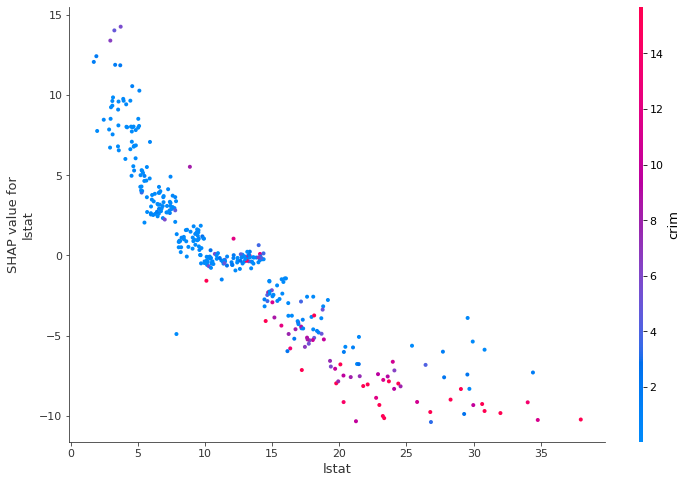

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.dependence_plot("lstat", vals, X_train, ax=ax)
fig.savefig("images/shap_dependence_plot.png", dpi=300)

Here is another `dependence plot` to explore the `dis` (distance to employment centers). It appears that this feature has little effect unless it is very small.

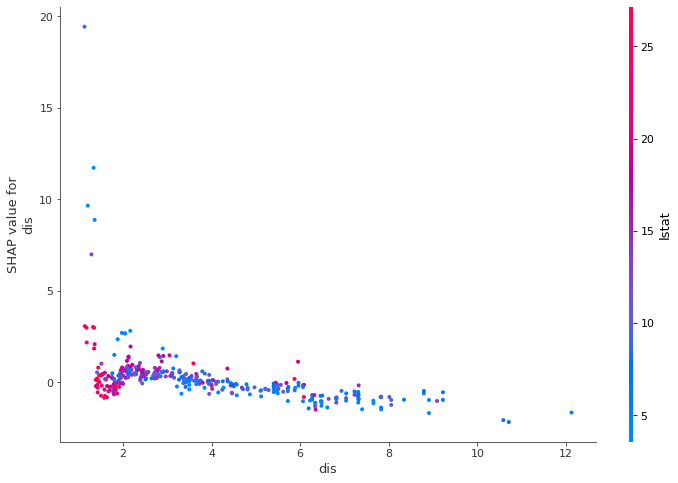

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.dependence_plot("dis", vals, X_train, ax=ax)
fig.savefig("images/shap_dependence_plot2.png", dpi=300)

## SHAP Summary Plot
Finally, we will look at the global effect of the features using a `summary plot`. The features at the top have the most impact to the model. From this view you can see that large values of `rm` (number of rooms) push up the target a lot, while medium and smaller values push it down a little.

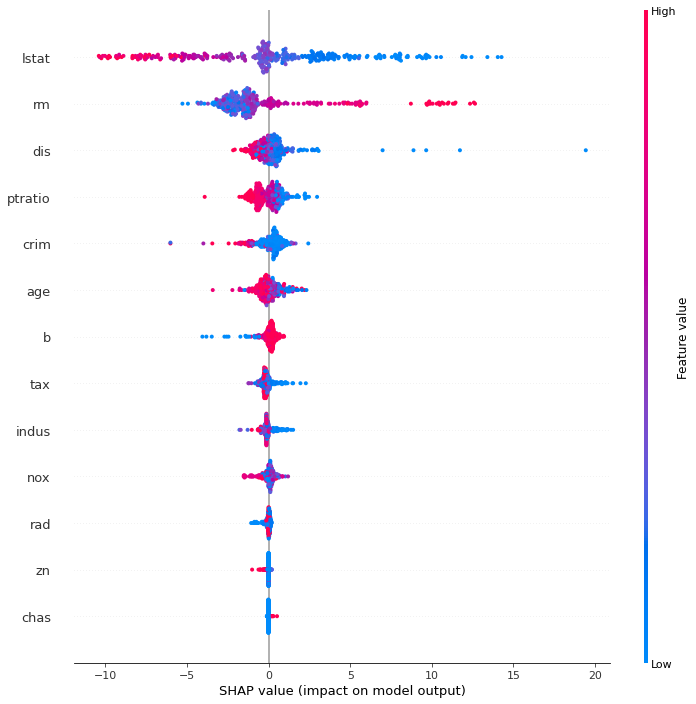

In [28]:
fig, ax = plt.subplots()
shap.summary_plot(vals, X_train, plot_size=(12, 12))
fig.savefig("images/shap_summary_plot.png", dpi=300)